# Diagram

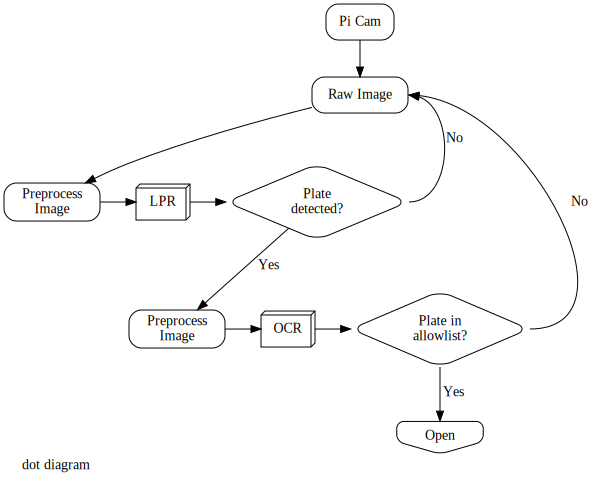

In [1]:
import graphviz

dot = graphviz.Digraph()

dot.attr('graph', labeljust='l', label='dot diagram', rankdir='TB')
dot.attr('node', shape='rect', style='rounded')
dot.engine = 'dot'

# graphviz.__version__, graphviz.version()

dot.node('cam', 'Pi Cam')
dot.node('img', 'Raw Image', shape='box')
dot.edge('cam:s', 'img:n')

with dot.subgraph(name='nocluster_0') as c:
    c.attr('graph', labeljust='l', label='LPR')
    c.attr(rank='same')

    c.node('pp1', 'Preprocess\n Image')
    c.node('lpr', 'LPR', shape='box3d')
    c.node('stage1', 'Plate\n detected?', shape='diamond')
    
    c.edge('pp1', 'lpr')#, constraint='false')


with dot.subgraph(name='nocluster_1') as c:
    c.attr('graph', labeljust='l', label='OCR')
    c.attr(rank='same')

    c.node('pp2', 'Preprocess\n Image')
    c.node('ocr', 'OCR', shape='box3d')
    c.node('stage2', 'Plate in\n allowlist?', shape='diamond')

    c.edge('pp2', 'ocr')


dot.node('open', 'Open', shape='invhouse')


dot.edge('img', 'pp1')
dot.edge('lpr', 'stage1')

dot.edge('stage1', 'pp2', label='Yes')
dot.edge('stage1:e', 'img:e', label='No')

dot.edge('ocr', 'stage2')
dot.edge('stage2:e', 'img:e', label='No')
dot.edge('stage2:s', 'open', label='Yes')


dot

In [2]:
from pprint import pprint
from pathlib import Path

example_dir = Path('./data/roboflow-dataset/valid')
oid = 'f5d1729aa333b284_jpg.rf.0a241e6c8cfebc2ee5a5a931954e5da7'

example_img = example_dir / f'{oid}.jpg'
example_xml = example_dir / f'{oid}.xml'
example_txt = example_dir / f'{oid}.txt'

# Preprocess Image

In [3]:
from matplotlib import pyplot as plt
import cv2

In [4]:
img = cv2.imread(str(example_img))

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#blur = cv2.GaussianBlur(gray,(3,3),0)
blur = cv2.bilateralFilter(gray, 13, 15, 15)

thresh = cv2.adaptiveThreshold(blur,
    255.0, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 3)
edge = cv2.Canny(blur, threshold1=123, threshold2=123)
 

## dilation for letters
#kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
#thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
axes[0,0].imshow(img)
axes[0,1].imshow(blur, cmap='gray')
axes[1,0].imshow(thresh, cmap='gray')
axes[1,1].imshow(edge, cmap='gray')
plt.show()

error: OpenCV(4.5.4) /build/source/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


# XML (Pascal VOC) to YOLO

In [ ]:
from xml.dom import minidom
import os
import glob

In [ ]:
class XML2YOLO:
    
    lut = {
           'license-plate': 0,
           #'vehicle':       1,
    }
    
    verbose = False
    
    def __init__(self):
        pass
    
    def convert_coordinates(self, size, box):
        dw = 1.0/size[0]
        dh = 1.0/size[1]
        x = (box[0]+box[1])/2.0
        y = (box[2]+box[3])/2.0
        w = box[1]-box[0]
        h = box[3]-box[2]
        x = x*dw
        w = w*dw
        y = y*dh
        h = h*dh
        return (x,y,w,h)

    def convert(self, infile, outfile):
        xmldoc = minidom.parse(infile)

        with open(outfile, "w") as f:

            itemlist = xmldoc.getElementsByTagName('object')
            size = xmldoc.getElementsByTagName('size')[0]
            width = int((size.getElementsByTagName('width')[0]).firstChild.data)
            height = int((size.getElementsByTagName('height')[0]).firstChild.data)

            for item in itemlist:
                
                # get bbox coordinates
                xmin = ((item.getElementsByTagName('bndbox')[0]).getElementsByTagName('xmin')[0]).firstChild.data
                ymin = ((item.getElementsByTagName('bndbox')[0]).getElementsByTagName('ymin')[0]).firstChild.data
                xmax = ((item.getElementsByTagName('bndbox')[0]).getElementsByTagName('xmax')[0]).firstChild.data
                ymax = ((item.getElementsByTagName('bndbox')[0]).getElementsByTagName('ymax')[0]).firstChild.data
                b = (float(xmin), float(xmax), float(ymin), float(ymax))
                bb = self.convert_coordinates((width,height), b)
                
                # get class label
                classid =  (item.getElementsByTagName('name')[0]).firstChild.data
                if classid in self.lut:
                    label_str = str(self.lut[classid])
                    f.write(label_str + " " + " ".join([("%.6f" % a) for a in bb]) + '\n')
                else:
                    label_str = "-1"
                    if self.verbose:
                        print("warning: label '%s' not in look-up table" % classid)

        if self.verbose:
            print("wrote %s" % outfile)

    def convert_dir(self, directory):
        xmls = directory.glob('*.xml')
        for xml in xmls:
            txt = directory / f'{xml.stem}.txt'
            self.convert(str(xml), str(txt))
        

In [ ]:
from pathlib import Path
import cv2

dirs = ['valid', 'train', 'test']
converter = XML2YOLO()
#converter.verbose = True

for d in dirs:
    path = Path('./lpr/roboflow-dataset') / d
    converter.convert_dir(path)
    for pic in path.glob('*.jpg'):
        img = cv2.imread(str(pic))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        cv2.imwrite(str(pic), img)